## Presentation for the application of deep reinforcement learning for autonomous driving

##### Important this project was realized with Python 3.7.9 and with the last version of the libraries used
##### With the Windows 0.9.12 version of Carla, although there should be no problem with other versions and linux versions under Ubuntu, but not yet tested!
https://github.com/carla-simulator/carla/releases/tag/0.9.12/

Please fill in the PATH_CARLA_EGG, your access path to this file which is normally located in Carla/PythonAPI/carla/dist/carla-*%d.%d-%s.egg when installing carla

In [2]:
#Initialization of my path
PATH_CARLA_EGG = '../DRL/Carla/PythonAPI/carla/dist/carla-*%d.%d-%s.egg'

Import of libraries and initialization of paths for the connection with Carla

In [3]:
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math
import gym

from gym import Env
from gym.spaces import Discrete, Box 

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torch.utils.tensorboard import SummaryWriter

#connection with the egg file
try:
    sys.path.append(glob.glob(PATH_CARLA_EGG % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla

### First version of my agent's environment

In [4]:
SHOW_PREVIEW = False
IM_WIDTH = 640
IM_HEIGHT = 480
MAX_EPISODE = 10


class CarEnv:
    metadata = {'render.modes': ['human']}
    SHOW_CAM = SHOW_PREVIEW
    STEER_AMT = 1.0
    im_width = IM_WIDTH
    im_height = IM_HEIGHT
    front_camera = None

    def __init__(self):
        """Initialization of Carla client and environment components"""
        
        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(20.0)
        self.world = self.client.get_world()
        self.blueprint_library = self.world.get_blueprint_library()
        self.model_3 = self.blueprint_library.filter("model3")[0]
        self.actor_list = []
        self.action_space = Discrete(3)
        self.observation_space = Box(0, 255, [IM_HEIGHT,IM_WIDTH,3])
        self.info = {'episode':0}
        self.iter = 0

    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.info = {'episode':0}
        self.iter = 0
        
        #reset the position of our vehicle
        self.transform = random.choice(self.world.get_map().get_spawn_points())
        self.vehicle = self.world.spawn_actor(self.model_3, self.transform)
        self.actor_list.append(self.vehicle)
        
        #reset the front rgb camera of the vehicle
        self.rgb_cam = self.blueprint_library.find('sensor.camera.rgb')
        self.rgb_cam.set_attribute("image_size_x", f"{self.im_width}")
        self.rgb_cam.set_attribute("image_size_y", f"{self.im_height}")
        self.rgb_cam.set_attribute("fov", f"110")

        transform = carla.Transform(carla.Location(x=2.5, z=0.7))
        not_spawn = True
        
        #The cases where our vehicle does not arrive to spawn, 
        #because there is already another agent on the place of the spawn
        while not_spawn:
            try :
                self.sensor = self.world.spawn_actor(self.rgb_cam, transform, attach_to=self.vehicle)
                not_spawn = False
            except Exception:
                not_spawn = True
            
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_img(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        #time.sleep(5)
    
        #reset of the collision sensor
        colsensor = self.blueprint_library.find("sensor.other.collision")
        self.colsensor = self.world.spawn_actor(colsensor, transform, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))
    
        #as long as we have not finished converting our camera data into RGB data
        while self.front_camera is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))

        return self.front_camera

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_img(self, image):
        """conversion of the raw image that Carla sends us from the RGB sensor, 
        into data of type (HEIGHT, WIDTH, 3)"""
        
        i = np.array(image.raw_data)
        #print(i.shape)
        i2 = i.reshape((self.im_height, self.im_width, 4))
        i3 = i2[:, :, :3]
        if self.SHOW_CAM:
            cv2.imshow("", i3)
            cv2.waitKey(1)
        self.front_camera = i3

    def step(self, action):
        if action == 0:
            #turn left
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer=-1*self.STEER_AMT))
        elif action == 1:
            #continue straight on
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer= 0))
        elif action == 2:
            #turn left
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer=1*self.STEER_AMT))

        #conversion to km/h
        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))

        if len(self.collision_hist) != 0:
            done = True
            reward = -100
        elif kmh < 40:
            done = False
            reward = -1
        else:
            done = False
            reward = 1

        if self.iter > MAX_EPISODE-1:
            done = True
        self.info['episode'] += 1
        self.iter += 1
        
        return self.front_camera , reward, done, self.info

### Implementation of my DQN module

In [5]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        """Initialization of a simple neural network with 3 layers, of MLP type
        and MSE loss"""
        
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
        #using the gpu
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        """activation relu with the following possible actions"""
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

### Implementation of my agent module

Initialization of the DQN module, to learn the model

In [6]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100, eps_end=0.05, eps_dec=5e-4):
        """Initialization of the hyperparameters 
            for learning and the neural network, 
            with a memory system"""
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        #initialization of the NN
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
        #For tensorboard
        self.writer = SummaryWriter()
        
        self.n_iter = 0

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        #espsilon for the exploration rate
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state.float())
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        #classic initialization for CUDA
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        #the forward step
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        #loss calculation
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        
        #the backward step and weight update
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.iter_cntr += 1
        #manual update of the exploration rate
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min
        
        #loss display in tensorboard
        self.writer.add_scalar('Loss/', loss, self.n_iter)
        self.n_iter += 1

### Start learning

Runtime can take up to 1h, if you have a GPU similar to mine, i.e. Nvidia gtx 1060 ti

If you don't want to start the training, you have the possibility to load a model already trained further down in the notebook

In [22]:
env = CarEnv()
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=5, n_actions=3, eps_end=0.1,
              input_dims=[480*640*3], lr=0.001, eps_dec=1e-3)
scores, eps_history = [], []

#number of iterations
n_games = 300
render = False

start_time = time.time()
for i in range(n_games):
    #initialization of the episode
    score = 0
    done = False
    #get the first observation
    observation = env.reset()
    #normalization of observations and transformation into a simple list
    flat_observation = observation.reshape(1,-1)[0]/255.0
    
    while not done:
        if render:
            cv2.imshow(f'Agent - preview', observation)
            cv2.waitKey(1)
            
        action = agent.choose_action(flat_observation.astype(float))
        observation_, reward, done, info = env.step(action)
        flat_observation_ = observation_.reshape(1,-1)[0]/255.0
        score += reward
        agent.store_transition(flat_observation.astype(float), action, reward, 
                                flat_observation_, done)
        agent.learn()
        flat_observation = flat_observation_
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    #average of the last 10 scores
    avg_score = np.mean(scores[-10:])
    if render:
        cv2.destroyWindow(f'Agent - preview')
    for actor in env.actor_list:
        actor.destroy()
    time_n = time.time() - start_time
    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon,
             'time %.2f s' % time_n)

KeyboardInterrupt: 

## New environment module

Recalculation of the reward function, which rewards according to the distance traveled between the starting point and the current point

In [9]:
SHOW_PREVIEW = False
IM_WIDTH = 640
IM_HEIGHT = 480
MAX_EPISODE = 10


class CarEnvDistanceReward:
    metadata = {'render.modes': ['human']}
    SHOW_CAM = SHOW_PREVIEW
    STEER_AMT = 1.0
    im_width = IM_WIDTH
    im_height = IM_HEIGHT
    front_camera = None

    def __init__(self, reward_function=None, verbose=0, EXPERIENCE_SECONDE = None):
        """Initialization of Carla client and environment components"""

        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(20.0)
        self.world = self.client.get_world()
        self.blueprint_library = self.world.get_blueprint_library()
        self.model_3 = self.blueprint_library.filter("model3")[0]
        self.actor_list = []
        self.action_space = Discrete(3)
        self.observation_space = Box(0, 255, [IM_HEIGHT,IM_WIDTH,3])
        self.info = {'episode':0}
        self.reward_function = reward_function
        self.verbose = verbose
        self.iter = 0
        self.experience_seconde = EXPERIENCE_SECONDE

    def reset(self):
        
        self.collision_hist = []
        self.actor_list = []
        self.info = {'episode':0}
        self.iter = 0
        
        #reset the position of our vehicle
        self.transform = random.choice(self.world.get_map().get_spawn_points())
        self.vehicle = self.world.spawn_actor(self.model_3, self.transform)
        self.actor_list.append(self.vehicle)

        #reset the front rgb camera of the vehicle
        self.rgb_cam = self.blueprint_library.find('sensor.camera.rgb')
        self.rgb_cam.set_attribute("image_size_x", f"{self.im_width}")
        self.rgb_cam.set_attribute("image_size_y", f"{self.im_height}")
        self.rgb_cam.set_attribute("fov", f"110")

        transform = carla.Transform(carla.Location(x=2.5, z=0.7))
        not_spawn = True

        #The cases where our vehicle does not arrive to spawn, 
        #because there is already another agent on the place of the spawn
        while not_spawn:
            try :
                self.sensor = self.world.spawn_actor(self.rgb_cam, transform, attach_to=self.vehicle)
                not_spawn = False
            except Exception:
                not_spawn = True
            
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_img(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        
        #reset of the collision sensor
        colsensor = self.blueprint_library.find("sensor.other.collision")
        self.colsensor = self.world.spawn_actor(colsensor, transform, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))
        
        #as long as we have not finished converting our camera data into RGB data
        while self.front_camera is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        
        #initial position of the vehicle
        self.initial_Location = self.vehicle.get_location()
        
        return self.front_camera

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_img(self, image):
        """conversion of the raw image that Carla sends us from the RGB sensor, 
        into data of type (HEIGHT, WIDTH, 3)"""
        
        i = np.array(image.raw_data)
        #print(i.shape)
        i2 = i.reshape((self.im_height, self.im_width, 4))
        i3 = i2[:, :, :3]
        if self.SHOW_CAM:
            cv2.imshow("", i3)
            cv2.waitKey(1)
        self.front_camera = i3

    def step(self, action):
        if action == 0:
            #turn left
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer=-1*self.STEER_AMT))
        elif action == 1:
            #continue straight on
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer= 0))
        elif action == 2:
             #turn left
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer=1*self.STEER_AMT))

        #v = self.vehicle.get_velocity()
        #kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))

        if len(self.collision_hist) != 0:
            #if collision
            done = True
            reward = -50
            if self.verbose == 1:
                print("Collision detected !")
        else :
            done = False
            #calculation of the distance from the starting point
            distance = self.vehicle.get_location().distance(self.initial_Location)
            if self.reward_function == None : 
                reward = distance
            else:
                reward = self.reward_function(distance)
            if self.verbose == 1:
                print("Obtain "+str(reward)+" reward, distance = "+str(distance))
        
        if self.experience_seconde != None :
            #iteration in second grade
            if time.time()-self.episode_start > self.experience_seconde:
                done = True
        else :
            #iteration by number of steps
            if self.iter > MAX_EPISODE-1 :
                done = True
            self.iter += 1
        self.info['episode'] += 1
        
        return self.front_camera , reward, done, self.info

##### Test with a reward function that rewards more the fact of covering a greater distance, function of exponential type, for positive x

In [15]:
def reward_function(x):
    return (x**3) / 1000

### Start learning with the new environment

Runtime can take up to 1h, if you have a GPU similar to mine, i.e. Nvidia gtx 1060 ti

If you don't want to start the training, you have the possibility to load a model already trained further down in the notebook

In [11]:
env = CarEnvDistanceReward()
#env = CarEnvDistanceReward(reward_function=reward_function)
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=5, n_actions=3, eps_end=0.1,
              input_dims=[480*640*3], lr=0.001, eps_dec=1e-3)
scores, eps_history = [], []

#number of iterations
n_games = 300
render = False

start_time = time.time()
for i in range(n_games):
    #initialization of the episode
    score = 0
    done = False
    #get the first observation
    observation = env.reset()
    #normalization of observations and transformation into a simple list
    flat_observation = observation.reshape(1,-1)[0]/255.0
    while not done:
        action = agent.choose_action(flat_observation.astype(float))
        if render:
            cv2.imshow(f'Agent - preview', observation)
            cv2.waitKey(1)
        
        observation_, reward, done, info = env.step(action)
        flat_observation_ = observation_.reshape(1,-1)[0]/255.0
        score += reward
        agent.store_transition(flat_observation.astype(float), action, reward, 
                                flat_observation_, done)
        agent.learn()
        flat_observation = flat_observation_
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-10:])
    if render:
        cv2.destroyWindow(f'Agent - preview')
    for actor in env.actor_list:
        actor.destroy()
    time_n = time.time() - start_time
    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon,
             'time %.2f s' % time_n)

episode  0 score -48.72 average score -48.72 epsilon 1.00 time 8.05 s
episode  1 score 76.54 average score 13.91 epsilon 0.99 time 30.10 s


KeyboardInterrupt: 

### Display of model data during training

(note: You can also see the evolution of the loss, during the training with TensorBoard)

ValueError: x and y must have same first dimension, but have shapes (300,) and (2,)

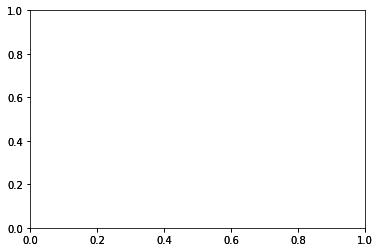

In [12]:
import matplotlib.pyplot as plt

start_time = time.time()
x = [i+1 for i in range(n_games)]
filename = 'data/DQN-EnvDistanceReward-'+str(n_games)+'-'+str(start_time)+'.jpg'

def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.plot(x, running_avg, color="C1")

    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)
    
plotLearning(x, scores, eps_history, filename)

### Saving the model

If you have trained your model before

In [11]:
import torch
from pathlib import Path

savepath = Path('model/model_DQN_EnvDistanceReward_WithRewardFunction_{}.pch'.format(str(n_games)+'-'+str(start_time)))

with savepath.open('wb') as file:
    torch.save(agent.Q_eval, file)

### Potential model loading

In [7]:
from pathlib import Path

#model learned about the environment with the rewards depending on the distance,
#with 600 iterations, the agent has learned to turn in circles
#savepath = Path('model/model_DQN_EnvDistanceReward_600-1635352803.4654603.pch')

#model learned with the same environment but with the cube function,
#where the distance is very important,
#the vehicle learned to go straight
#savepath = Path('model/model_DQN_EnvDistanceReward_WithRewardFunction_300-1635362488.656119.pch')

#model learned about the environment with the rewards depending on the distance,
#with 300 iterations, the agent has learned to turn in circles 
#and the beginning of a collision avoidance behaviour.
#but with the delay due to the latency during learning, the rendering is not perfect at all
savepath = Path('model/model_DQN_EnvDistanceReward_300-1635331329.0202696.pch')
with savepath.open('rb') as file:
    model = T.load(file)

### If the model is already present

If you have launched the learning cells

In [13]:
model = agent.Q_eval

## Application of the model learned on the simulator

In [10]:
episode = 5
render = True
#env = CarEnv()
env = CarEnvDistanceReward(EXPERIENCE_SECONDE= 10)
start_time = time.time()
for i in range(episode):
    score = 0
    done = False
    observation = env.reset()
    flat_observation = observation.reshape(1,-1)[0]/255.0
    try : 
        while not done:

            if render:
                cv2.imshow(f'Agent - preview', observation)
                cv2.waitKey(1)

            data = T.tensor(flat_observation).float()

            action = model.forward(data)
            action = action.detach().numpy().argmax()

            observation_, reward, done, info = env.step(action)
            flat_observation_ = observation_.reshape(1,-1)[0]/255.0
            score += reward
            flat_observation = flat_observation_
            observation = observation_

    finally : 
        if render:
            cv2.destroyWindow(f'Agent - preview')
        for actor in env.actor_list:
            actor.destroy()
        time_n = time.time() - start_time
        print('episode ', i, 'score %.2f' % score,'time %.2f s' % time_n)

episode  0 score 1002.69 time 10.05 s
episode  1 score 2464.82 time 20.35 s
episode  2 score 2737.31 time 30.62 s
episode  3 score 281.62 time 37.02 s
episode  4 score -14.62 time 40.90 s
